BACKTEST USER GUIDE:

1. Run all code until you've run the backtest function
2. backtest(big dataframe, startdate, enddate, rebalancing period, cap ceiling, coins)

EG (data, 'Jan 01, 2017', 'Jan 01, 2018', rb=7, cc=0.1, coins=20)

In [23]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
#import seaborn as sns
#sns.set(style='darkgrid', context='talk', palette='Dark2')

my_year_month_fmt = mdates.DateFormatter('%m/%y')

In [2]:
#DATA PREPARATION
data = np.load('/home/isabelle/Downloads/latest_coin_data.pkl')
#drop null data
data = data.dropna()


#convert all dates to datetime dates
#data.columns = pd.to_datetime(data.columns).date

NOTE: Not converting to datetime.date because format not compatible with slicing, code for datetime left above

In [3]:
def share_cap_recurse(market_cap_list, num_coins, cap_ceiling_amount, final_cap_list):

    not_realloc_val = 0

    realloc_val = 0

    num_final = 0

    new_market_cap_list = []

    

    for i in range(0, len(market_cap_list)):

        if(market_cap_list[i] > cap_ceiling_amount):

            final_cap_list.append(cap_ceiling_amount)

            realloc_val += market_cap_list[i] - cap_ceiling_amount

            num_final += 1

        else:

            not_realloc_val += market_cap_list[i]

     

    if(num_final!=0):

        new_market_cap_list = [x * (1+(realloc_val/not_realloc_val)) for x in market_cap_list[num_final:]]

    else:

        new_market_cap_list = deepcopy(market_cap_list)

    

    if len(final_cap_list) == num_coins:

        return

    elif (new_market_cap_list[0] <= cap_ceiling_amount): #assumes ordered desc in market cap

        for cap in new_market_cap_list:

            final_cap_list.append(cap)

        return       

    else:

        share_cap_recurse(new_market_cap_list, num_coins, cap_ceiling_amount, final_cap_list)

        

def share_cap(market_cap_list, cap_ceiling_percent):  #CHANGE CAP CEILING HERE

    total_cap = sum(market_cap_list)

    cap_ceiling_amount = total_cap * cap_ceiling_percent

    final_cap_list = []

    

    share_cap_recurse(market_cap_list, len(market_cap_list), cap_ceiling_amount, final_cap_list)

    

    return (final_cap_list)

Backtest function: pass data, the start and end date, rebalancing duration and top number of coins you require)

In [15]:
#Backtest function
def backtest(data, startdate, enddate, rb, cc, coins):
    
    # Initialize a close_price list
    close_list = list()
    # Making a list of all close_prices
    for date in data.index:
        for column in data.columns:
            close_list.append(data[column][date]['close_price'])

    # Splitting list into 133 lists (one per coin)
    close_list2 = [close_list[i:i+916] for i  in range(0, len(close_list), 916)]

    # Make an array
    close_ar = np.asarray(close_list2)
    
    # Make Close DataFrame
    close_df = pd.DataFrame(data = close_ar, index = data.index, columns = data.columns)
    close_df = close_df[close_df.columns[::-1]]
    
    
    
    # Initialize a market_cap list
    market_list = list()
    # Making a list of all market_cap
    for date in data.index:
        for column in data.columns:
            market_list.append(data[column][date]['market_cap'])

    # Splitting list into 133 lists (one per coin)
    market_list2 = [market_list[i:i+916] for i  in range(0, len(market_list), 916)]

    # Make an array
    market_ar = np.asarray(market_list2)
    
    # Make Market Cap DataFrame
    market_df = pd.DataFrame(data = market_ar, index = data.index, columns = data.columns)
    market_df = market_df[market_df.columns[::-1]]
    
    
    
    
    #Selecting data for startdate to enddate
    selectedmarket = market_df.loc[:, startdate:enddate:rb]
    selectedmarket = selectedmarket.iloc[:, :-1]
    selectedclose = close_df.loc[:, startdate:enddate:rb]
    
    
    #Generating returns dataframe
    selectedclose1 = selectedclose.copy().T
    selectedreturns = selectedclose1.pct_change(1).T
    cols = selectedreturns.columns[:-1]
    selectedreturns = selectedreturns.drop(startdate, 1)
    selectedreturns.columns = cols
    
    
    #FOR LOOP
    topmc = {}
    sc = {}
    tc = {}
    ps = {}
    invest = {}
    returns = {}
    lg_returns = {}
    selectedmc = {}

    #for every date
    for column in selectedmarket:
        #sort in descending order
        selectedmc[column] = selectedmarket[column].sort_values(ascending=False)
    
        #take the top coins
        topmc[column] = selectedmc[column].head(coins)
        #take the index of the top coins
        topcoins = {}
        topcoins[column] = topmc[column].index
    
        #get the share cap of the top 20
        sc[column] = share_cap(topmc[column], cc)

        #total cap of top 20
        tc[column] = sum(sc[column])

        #percentage share to be allocated for top 20
        ps[column] = [x / tc[column] for x in sc[column] ]

        #building dataframe of top20 coins by mc and %share to be invested
        invest[column] = pd.DataFrame()
        invest[column] = pd.DataFrame({'coin': topcoins[column], 'pct_share': ps[column]})
        invest[column] = invest[column].set_index('coin')
        
        
        #building dataframe of top 20 coins by mc and close price of that week
        for name in selectedreturns:
            returns[column] = pd.DataFrame()
            returns[column] = pd.DataFrame({'returns': selectedreturns[column]})
            returns[column] = returns[column].loc[topcoins[column]]
            
    #Calculating simple returns
    portfolio_total_returns = list()

    #for loop to generate portfolio returns for a particular week
    portfolio_simple_returns = {}

    for i, df in invest.items():
        portfolio_simple_returns[i] = invest[i].transpose().dot(returns[i])
        portfolio_total_returns.append(portfolio_simple_returns[i]['returns'])
        
    #compiling and cleaning the table into a readable format
    final_portfolio_simple_returns = pd.DataFrame(portfolio_total_returns)
    final_portfolio_simple_returns.columns = ['weekly_portfolio_simple_returns']
    final_portfolio_simple_returns['date'] = selectedreturns.T.index
    final_portfolio_simple_returns = final_portfolio_simple_returns.set_index('date')
    
    
    
    final_cum = (1 + final_portfolio_simple_returns).cumprod()

    
    #graphing portfolio returns
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))
    ax1.plot(final_portfolio_simple_returns.index, final_portfolio_simple_returns)
    ax1.set_ylabel('Portfolio weekly simple returns')

    ax2.plot(final_cum.index, final_cum)
    ax2.set_ylabel('Portfolio cumulative simple returns')

    plt.show()
    
    
    # Calculating the time-related parameters of the simulation
    days_per_year = 52 * 5
    total_days_in_simulation = selectedmarket.shape[0]
    number_of_years = total_days_in_simulation / days_per_year

    # The last data point will give us the total portfolio return
    total_portfolio_return = final_cum['weekly_portfolio_simple_returns'].iloc[-1]

    print('Total portfolio return is: ' +
          '{:5.2f}'.format(100 * total_portfolio_return) + '%')

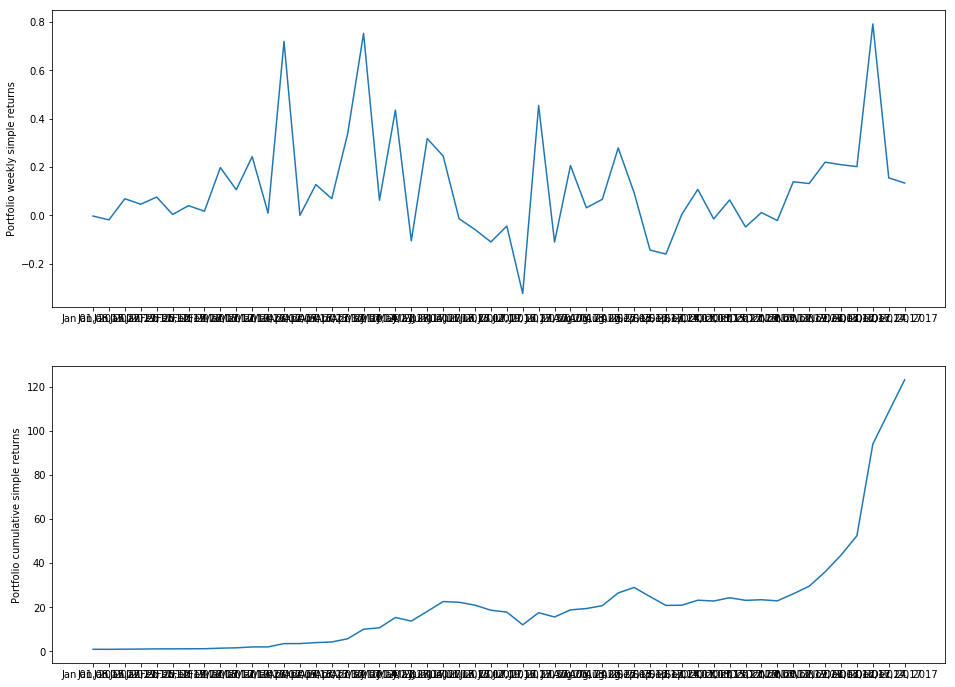

Total portfolio return is: 12315.21%


In [17]:
backtest(data, 'Jan 01, 2017', 'Jan 01, 2018', rb=7, cc=0.1, coins=20)

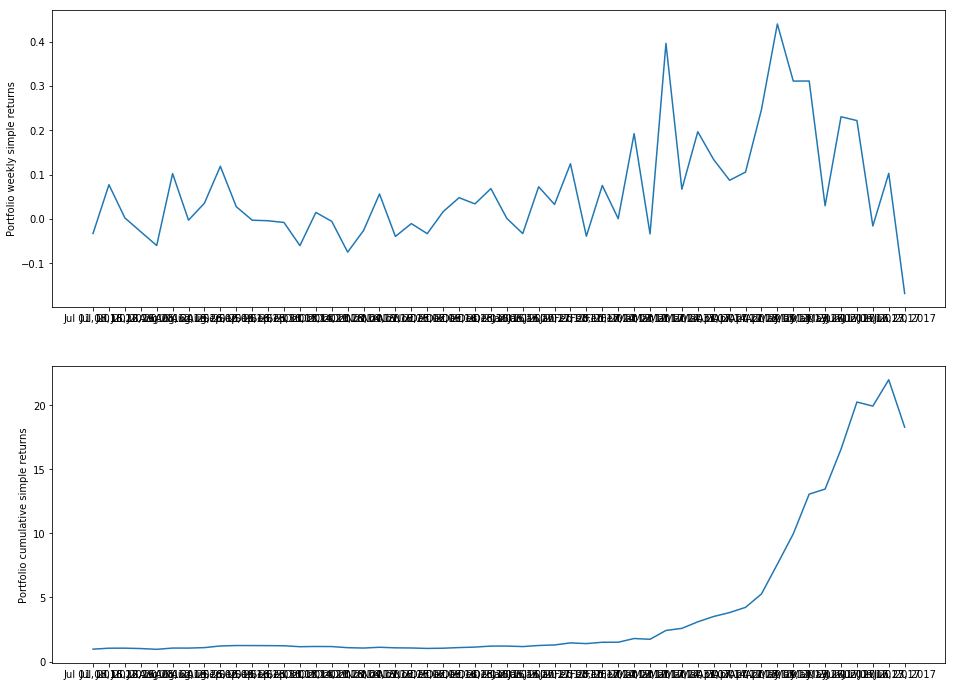

Total portfolio return is: 1829.63%


In [19]:
backtest(data, 'Jul 01, 2016', 'Jul 01, 2017', rb=7, cc=0.1, coins=20)

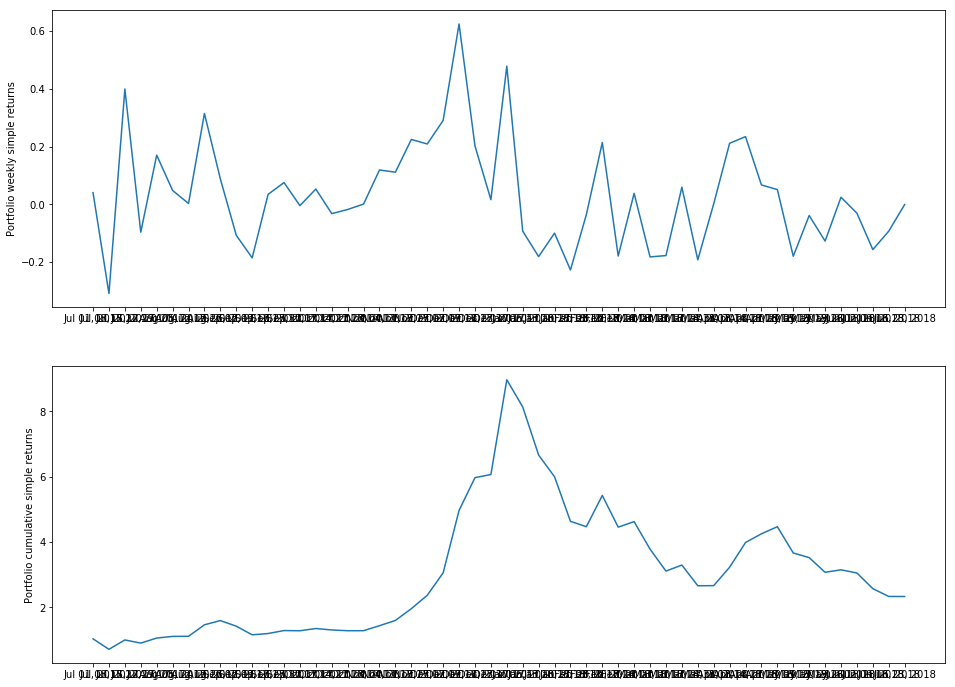

Total portfolio return is: 233.51%


In [20]:
backtest(data, 'Jul 01, 2017', 'Jul 01, 2018', rb=7, cc=0.1, coins=20)

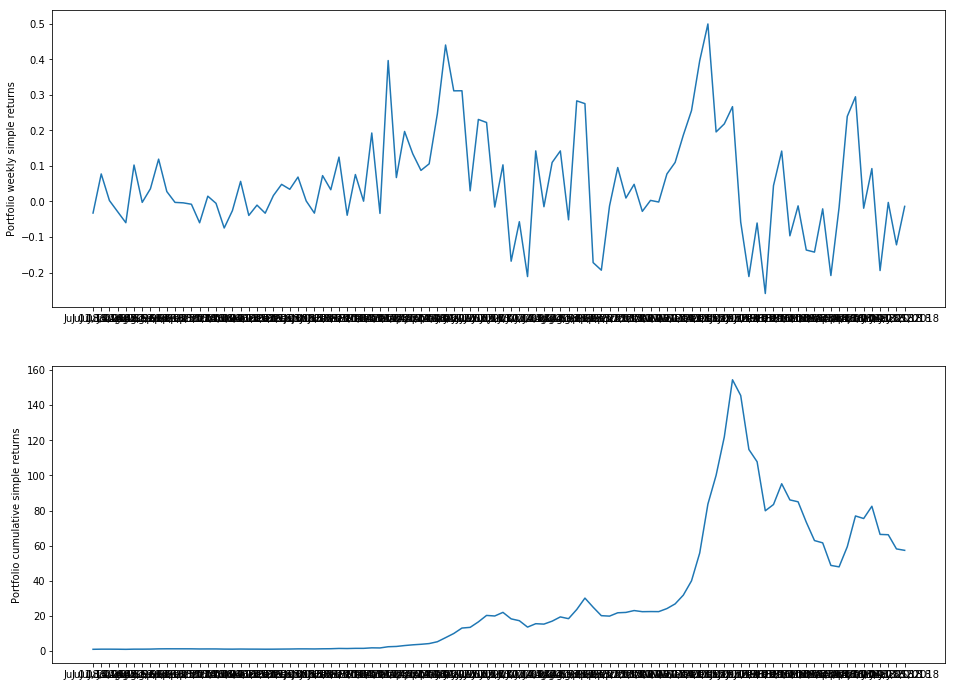

Total portfolio return is: 5732.68%


In [22]:
backtest(data, 'Jul 01, 2016', 'Jun 01, 2018', rb=7, cc=0.1, coins=20)